In [1]:
import autograd.numpy as np
import autograd.numpy.random as npr
npr.seed(0)

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_style("white")
sns.set_context("talk")

from ssm.models import SLDS
from ssm.util import random_rotation, find_permutation

In [2]:
# Set the parameters of the HMM
T = 1000    # number of time bins
K = 5       # number of discrete states
D = 2       # number of latent dimensions
N = 10      # number of observed dimensions

In [3]:
# Make an SLDS with the true parameters
true_slds = SLDS(N, K, D, emissions="gaussian")
for k in range(K):
    true_slds.dynamics.As[k] = .95 * random_rotation(D, theta=(k+1) * np.pi/20)
z, x, y = true_slds.sample(T)

# Mask off some data
mask = npr.rand(T, N) < 0.9

Fitting SLDS with SVI
Initializing with an ARHMM using 25 steps of EM.
Done
Iteration 0.  ELBO: -934.5
Iteration 100.  ELBO: -232.0
Iteration 200.  ELBO: 184.5
Iteration 300.  ELBO: 514.3
Iteration 400.  ELBO: 778.4
Iteration 500.  ELBO: 1005.3
Iteration 600.  ELBO: 1201.1
Iteration 700.  ELBO: 1332.6
Iteration 800.  ELBO: 1434.2
Iteration 900.  ELBO: 1595.6


Text(0,0.5,'ELBO')

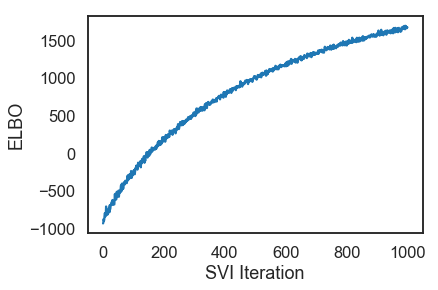

In [4]:
print("Fitting SLDS with SVI")
slds = SLDS(N, K, D, emissions="gaussian")
slds_elbos, (slds_x, slds_x_var) = slds.fit(y * mask, masks=mask, num_iters=1000, print_intvl=100)

plt.plot(slds_elbos)
plt.xlabel("SVI Iteration")
plt.ylabel("ELBO")

In [5]:
# Find the permutation that matches the true and inferred states
slds.permute(find_permutation(z, slds.most_likely_states(slds_x, y)))
slds_z = slds.most_likely_states(slds_x, y)

In [6]:
# Smooth the observations
slds_y = slds.smooth(slds_x, y)

(0, 200)

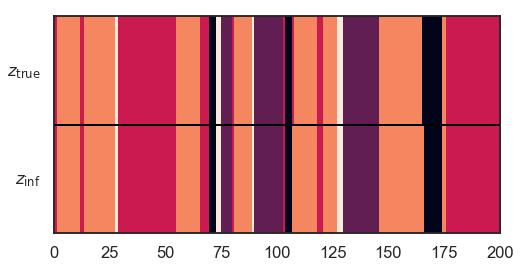

In [7]:
# Plot the true and inferred states
xlim = (0, 200)

plt.figure(figsize=(8,4))
plt.imshow(np.column_stack((z, slds_z)).T, aspect="auto")
plt.plot(xlim, [0.5, 0.5], '-k', lw=2)
plt.yticks([0, 1], ["$z_{\\mathrm{true}}$", "$z_{\\mathrm{inf}}$"])
plt.xlim(xlim)

(0, 200)

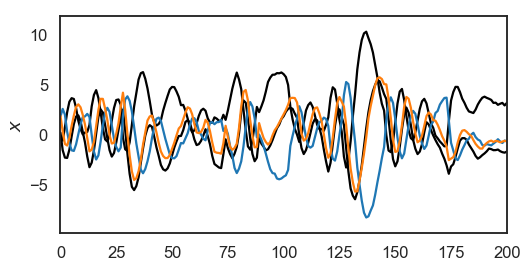

In [8]:
plt.figure(figsize=(8,4))
plt.plot(x, '-k')
plt.plot(slds_x, '-')
plt.ylabel("$x$")
plt.xlim(xlim)

(0, 200)

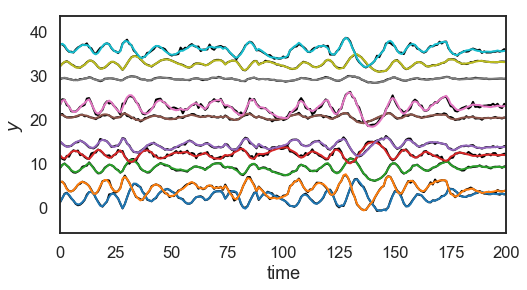

In [9]:
# Plot the smoothed observations
plt.figure(figsize=(8,4))
plt.plot(y + 4 * np.arange(N), '-k', lw=2)
plt.plot(slds_y + 4 * np.arange(N), '-', lw=2)
plt.ylabel("$y$")
plt.xlabel("time")
plt.xlim(xlim)